# **FRUIT IDENTIFICATION USING RESENT9 ARCHITECTURE BASED CNN DEEP LEARNING MODEL🍅🍇🍉🍌🍒🍓🥑🥝🥭**

Fruits are very good source of Nutrients and Fiber. They are juicy & sweet and also impart Freshness in our diet.
As important it is to eat foods, it is also very important to identify what fruit are we exactly eating, sometimes people with conditions require fruits which are rich in some particular Nutrient or Fiber.

**The very aim of this Deep learning Model is to predict the label/name of the given Fruit just by looking at it's Picture.**

## **IMPORTING THE REQUIRED LIBRARIES**

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
!pip install opendatasets

##**DOWNLOADING THE DATASET USING OPENDATASETS FROM KAGGLE**

In [3]:
import opendatasets as od

In [4]:
od.download('https://www.kaggle.com/moltean/fruits')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hiteshraa
Your Kaggle Key: ··········


100%|██████████| 1.28G/1.28G [00:59<00:00, 23.3MB/s]


In [5]:
data_dir = '/content/fruits/fruits-360_dataset/fruits-360'
print(os.listdir(data_dir))

['Training', 'readme.md', 'test-multiple_fruits', 'LICENSE', 'Test', 'papers']


In [6]:
len(os.listdir(data_dir + '/Training'))

131

####USING SIMPLE TENSOR TRANSFORM WHILE MAKING AN IMAGE FOLDER OBJECT BECAUSE WE WILL USE THIS TO FIND MEAN AND STANDARD DEVIATIONS FOR IMAGE NORMALISATION

In [7]:
train_ds = ImageFolder(data_dir + '/Training', tt.ToTensor())

In [8]:
train_ds[0]

(tensor([[[0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ...,

In [9]:
train_ds.classes[:10]

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3']

*CREATING A DATALOADER FOR IMAGE VISUALIZATION AND CALCULATING IMAGE MEAN AND STD DEVIATIONS*

In [10]:
batch_size = 100
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 3, pin_memory = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
train_ds[0][0].shape

torch.Size([3, 100, 100])

WE HAVE 100 X 100 PIXEL IMAGES WITH 3 COLOUR CHANNELS (RGB)

HERE, WE DEFINE A HELPER FUNCTION show_example TO VISUALIZE IMAGES

In [12]:
def show_example(img, label):
  print('Label: ', train_ds.classes[label], "("+str(label)+")")
  plt.imshow(img.permute(1, 2, 0))

Label:  Apple Braeburn (0)


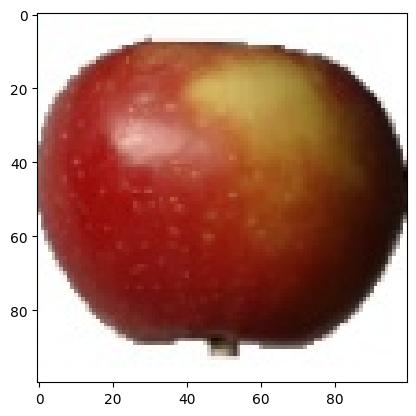

In [13]:
show_example(*train_ds[100])

In [14]:
len(train_ds)

67692

WE HAVE 67692 IMAGES FOR TRAINING

LET'S DEFINE A HELPER TO FUNCTION TO VISUALIZE A FULL BATCH OF IMAGES

In [15]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (15, 20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow = 10).permute(1, 2, 0))
    break

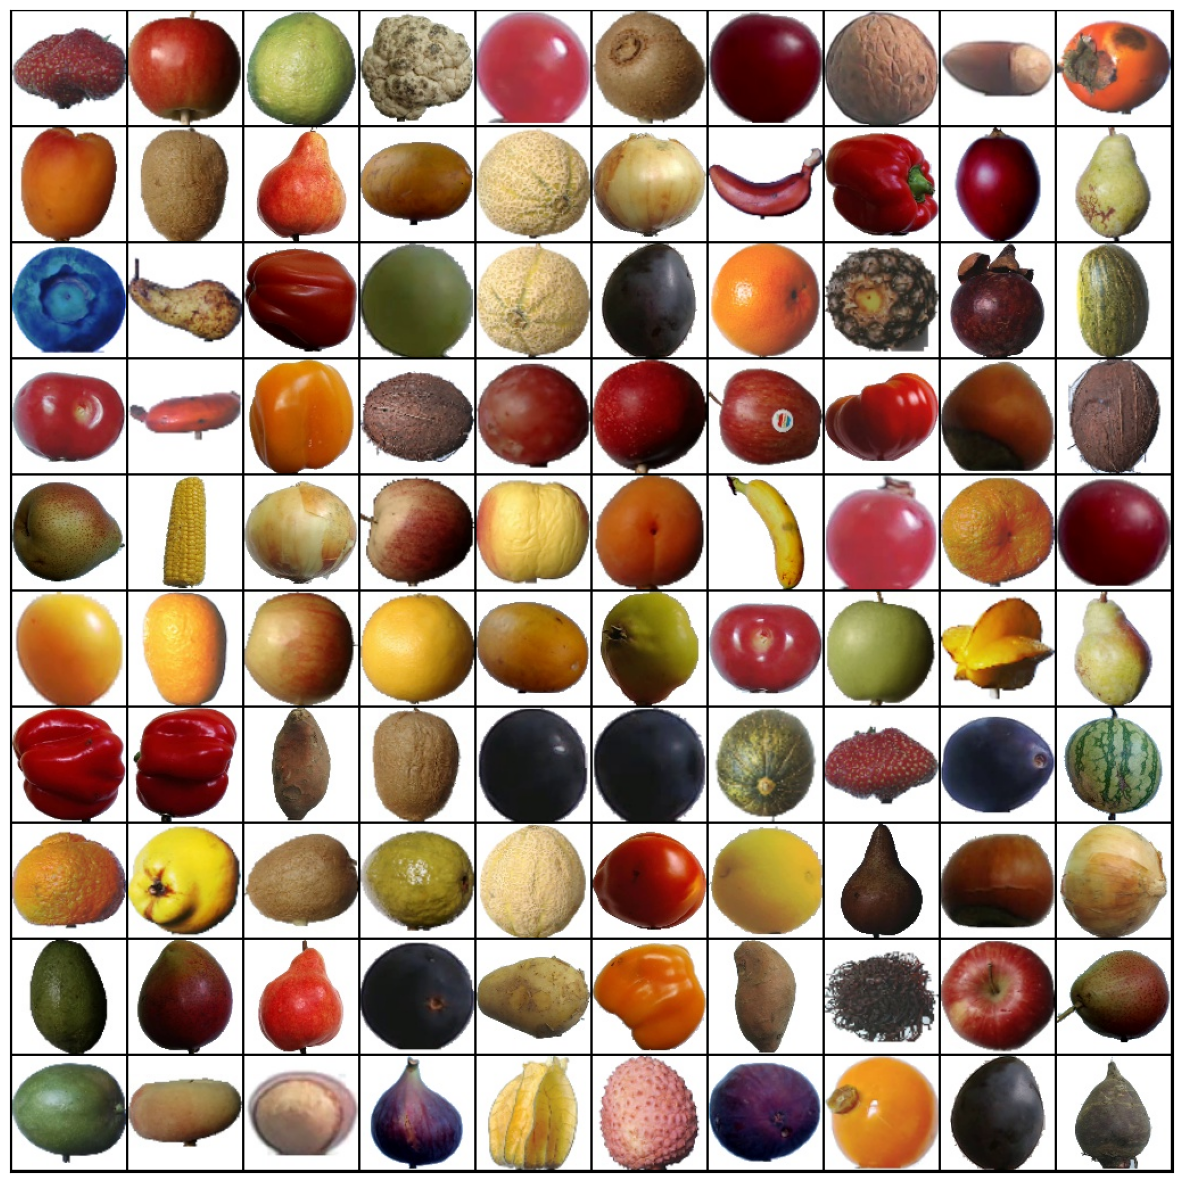

In [16]:
show_batch(train_dl)

WE HAVE GOOD QUALITY IMAGES AND SOMETIMES WHEN GOOD QUALITY IMAGES ARE PASSED DIRECTLY INTO THE MODEL, IT MAY LEAD TO OVERFITTING. WE WILL COUNTER THIS PROBLEM UP NEXT

### CALCULATING MEAN AND STD DEVIATION OF IMAGES FOR DATA NORMALISATION

WE DEFINED A HELPER FUNCTION get_mean_std TO CALCULATE IMAGE MEAN AND STANDARD DEVIATION FOR IMAGE NORMALISATION.

In [17]:
def get_mean_std(loader):
  ch_sum, ch_sq_sum, num_batches = 0, 0, 0
  for data, _ in loader:
    ch_sum += torch.mean(data, dim=[0,2,3])
    ch_sq_sum += torch.mean(data**2, dim=[0,2,3])
    num_batches += 1
  mean = ch_sum/num_batches
  std = (ch_sq_sum/num_batches - mean ** 2) ** 0.5
  return mean, std

In [18]:
mean, std = get_mean_std(train_dl)

In [19]:
mean

tensor([0.6841, 0.5787, 0.5039])

In [20]:
std

tensor([0.3037, 0.3598, 0.3909])

In [21]:
mean_values = tuple(mean.numpy())
std_values = tuple(mean.numpy())

### IMPORTING THE TRAINING AND VALIDATION DATASET USING IMAGEFOLDER METHOD OF PYTORCH AND AUGEMENTING & NORMALISING THE DATA.

LETS MAKE A NEW IMAGEFOLDER OBJECT BUT NOW WE ALSO PERFORM NORMALISATION AND AUGEMENTATION



In [22]:
stats = (mean_values, std_values)
train_tfms = tt.Compose([tt.RandomCrop(100, padding=4, padding_mode='reflect'), tt.RandomHorizontalFlip(), tt.ToTensor(),tt.Normalize(*stats,inplace=True)])

WE DON'T NEED TO DO THESE AUGUMENATATON ON THE VALIDATION SET IMAGES

In [23]:
train_ds1 = ImageFolder(data_dir + '/Training', train_tfms)

In [24]:
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [25]:
valid_ds = ImageFolder(data_dir + '/Test', valid_tfms)

Label:  Apple Braeburn (0)


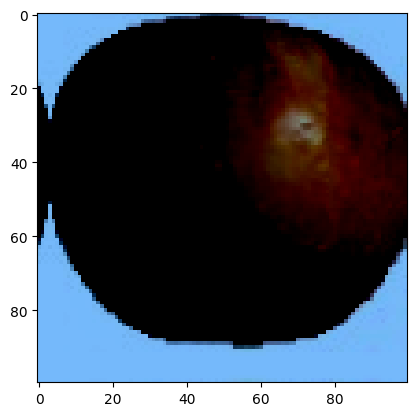

In [26]:
show_example(*train_ds1[0])

HE IMAGE HAS CHANGED AND THIS CHANGE HELPS A LOT IN MAKING THE MODEL MORE GENERAL.

## CREATING DATALOADERS TO RETREIVE BATCHES OF IMAGES.


In [27]:
train_dl1 = DataLoader(train_ds1, batch_size, shuffle = True, num_workers = 3, pin_memory = True)

In [28]:
valid_dl = DataLoader(valid_ds, batch_size, shuffle = True, num_workers = 3, pin_memory = True)

In [29]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

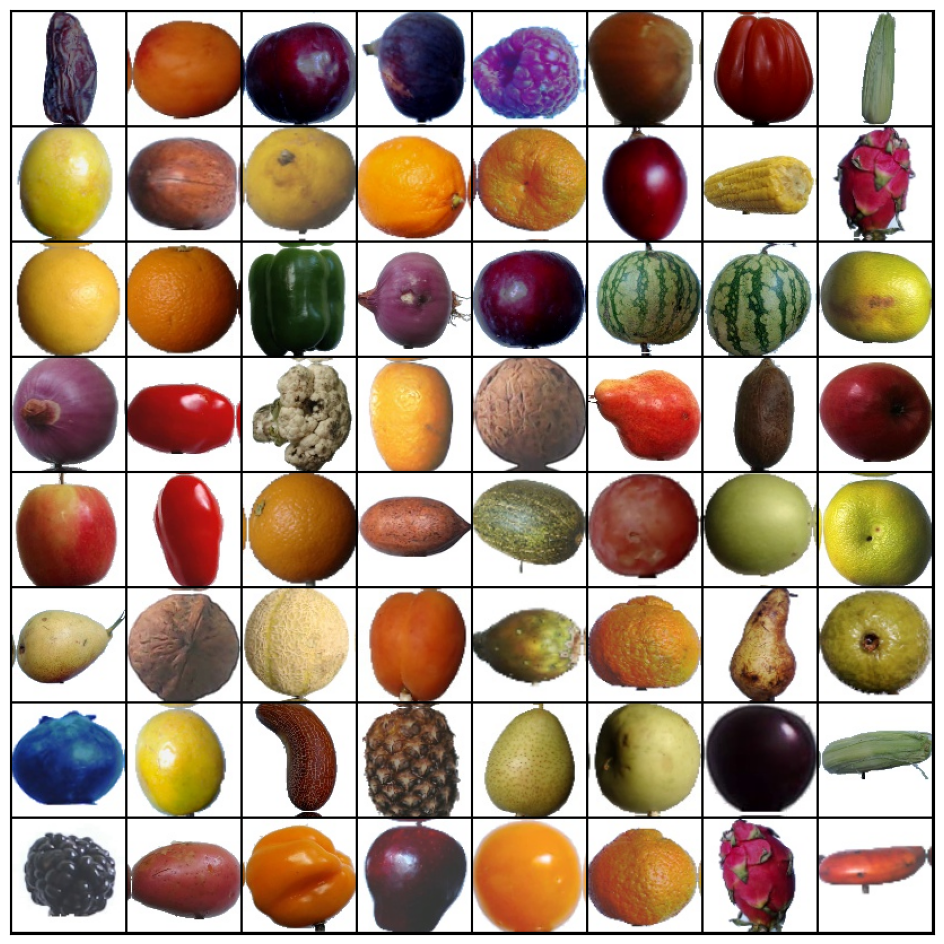

In [30]:
show_batch(train_dl1)

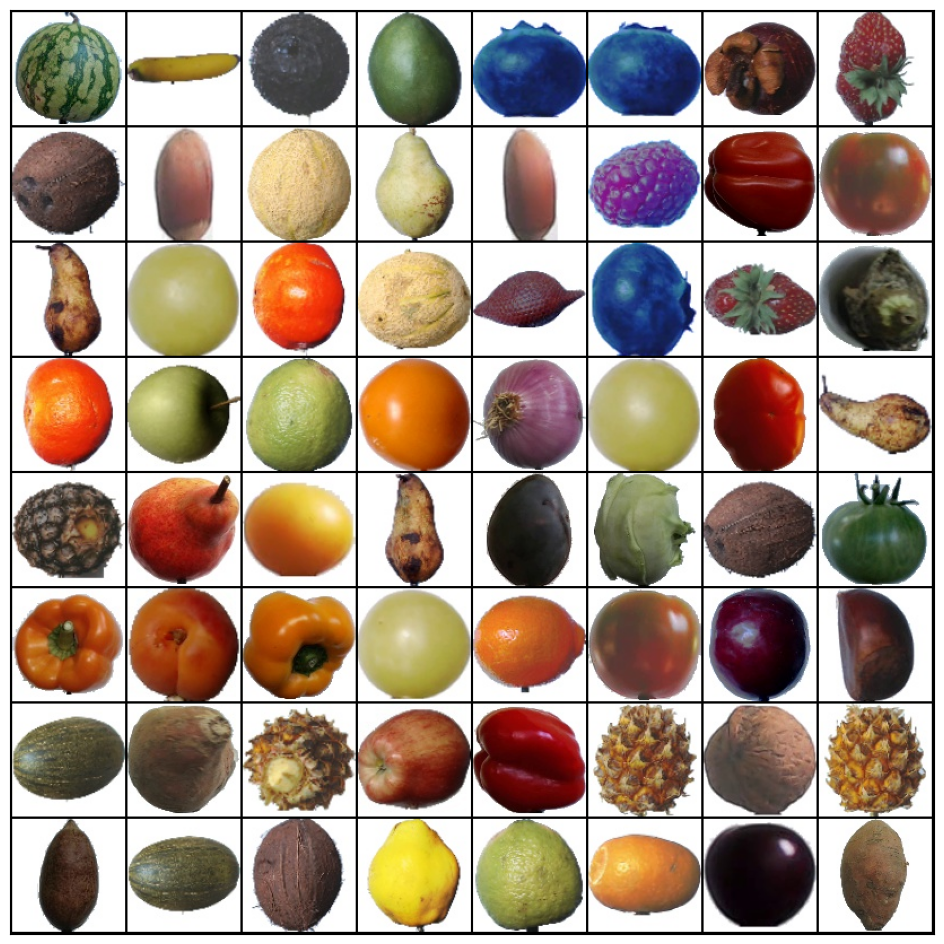

In [31]:
show_batch(valid_dl)

## SHIFTING THE DATALOADERS ON THE GPU

In [34]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [35]:
device = get_default_device()
device

device(type='cuda')

In [36]:
train_dl1 = DeviceDataLoader(train_dl1, device)
valid_dl = DeviceDataLoader(valid_dl, device)

### EXTENDING THE nn.Module CLASS FOR REQUIRED FUNCTIONS.

In [49]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## **DEFINING THE MAIN RESNET9 ARCHITECTURE BASED CNN MODEL.**

In [50]:
def conv_block(in_channels, out_channels, pool = False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True)]
  if pool: layers.append(nn.MaxPool2d(2, stride = 2))
  return nn.Sequential(*layers)

In [51]:
class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool = True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

    self.conv3 = conv_block(128, 256, pool = True)
    self.conv4 = conv_block(256, 512, pool = True)
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

    self.conv5 = conv_block(512, 1024, pool=True)                           #100 x 1024 x 5 x 5
    self.conv6 = conv_block(1024, 2048, pool=True)                          #100 x 2048 x 2 x 2
    self.res3 = nn.Sequential(conv_block(2048, 2048), conv_block(2048, 2048))   #100 x 2048 x 2 x 2

    self.classifier = nn.Sequential(nn.MaxPool2d(2),
                                    nn.Flatten(),
                                    nn.Dropout(0.15),
                                    nn.Linear(2048, num_classes))

  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.conv5(out)
    out = self.conv6(out)
    out = self.res3(out) + out
    out = self.classifier(out)

    return out

### CREATING THE MODEL OBJECT AND SHIFTING IT ON THE GPU

In [52]:
model = to_device(ResNet9(3, 131), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [53]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### TRAINING THE MODEL AND EVALUATING SIMUNTANEOUSLY.

In [54]:
epochs = 6
max_lr = 0.01
grad_clip = 0.101
weight_decay = 1e-4
opt_func = torch.optim.Adam
history = []

In [55]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl1, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], last_lr: 0.00603, train_loss: 0.6559, val_loss: 1.1746, val_acc: 0.7992
Epoch [1], last_lr: 0.00994, train_loss: 0.2888, val_loss: 3.7805, val_acc: 0.4986
Epoch [2], last_lr: 0.00812, train_loss: 0.1745, val_loss: 0.2976, val_acc: 0.9251
Epoch [3], last_lr: 0.00463, train_loss: 0.0951, val_loss: 0.2013, val_acc: 0.9438
Epoch [4], last_lr: 0.00133, train_loss: 0.0261, val_loss: 0.0649, val_acc: 0.9838
Epoch [5], last_lr: 0.00000, train_loss: 0.0020, val_loss: 0.0491, val_acc: 0.9924
CPU times: user 24min 46s, sys: 23min 22s, total: 48min 9s
Wall time: 51min 20s


## **PLOTTING MODEL ACCURACY, LOSS AND LEARNING RATES AGAINST NO OF EPOCHS.**

In [56]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

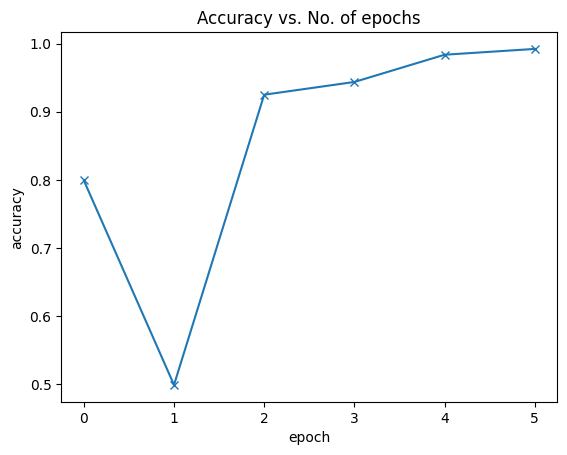

In [57]:
plot_accuracies(history)

In [58]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

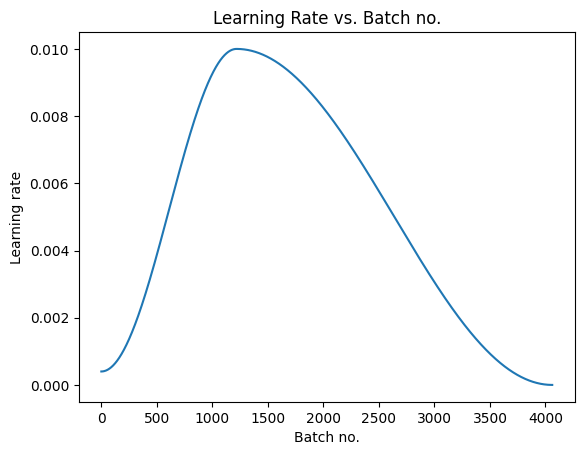

In [59]:
plot_lrs(history)

## **TESTING THE MODEL ON INDIVIDUAL IMAGES.**

In [60]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: Apple Braeburn , Predicted: Apple Braeburn


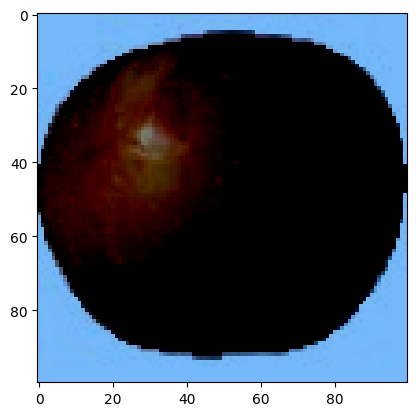

In [61]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Apple Pink Lady , Predicted: Apple Pink Lady


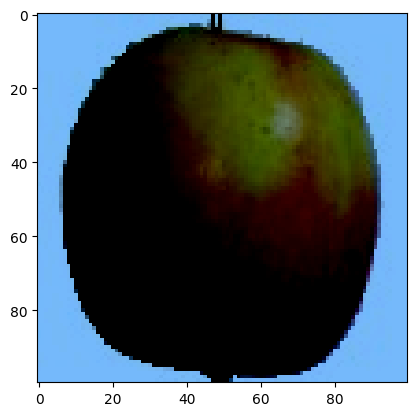

In [62]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Tomato 1 , Predicted: Tomato 1


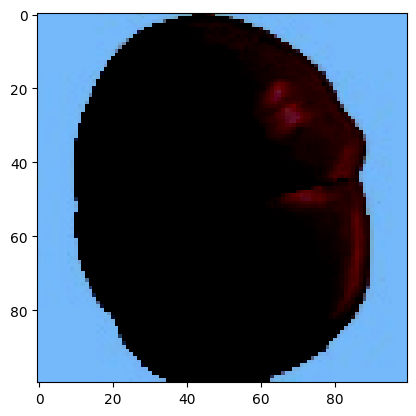

In [77]:
img, label = valid_ds[20800]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_ds.classes[label], ', Predicted:', predict_image(img, model))

In [78]:
torch.save(model.state_dict, 'Fruit_classifier.pth')